In [1]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [2]:
dataset1=read_csv('set2.csv',index_col=0)
dataset2=dataset1[['apt','inc','hloan','ir','cpi','fed','exp','bond','m2','savings','hccsi','kospi']]

In [3]:
dataset2

,apt,inc,hloan,ir,cpi,fed,exp,bond,m2,savings,hccsi,kospi
date,,,,,,,,,,,,
2011-07-01,274.006649,3897608.967,666961.6,3.25,94.982,0.25,60048.466667,4.190,1705451.5,42005.300000,128.8,2133.21
2011-08-01,272.827250,3897608.967,672207.1,3.25,95.620,0.25,60048.466667,3.870,1719437.8,42005.300000,133.7,1880.11
2011-09-01,269.895817,3897608.967,673546.5,3.25,95.529,0.25,60048.466667,3.930,1729531.1,42005.300000,129.2,1769.65
2011-10-01,268.487226,3883351.086,679967.1,3.25,95.347,0.25,61810.700000,3.860,1742645.4,44872.866667,119.0,1909.03
2011-11-01,265.473188,3883351.086,684084.8,3.25,95.438,0.25,61810.700000,3.770,1753296.4,44872.866667,110.2,1847.51
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,473.113918,5027612.000,1304442.1,0.50,105.500,0.25,68010.566667,1.513,3100373.4,61117.466667,122.8,2326.17
2020-09-01,447.565669,5027612.000,1314897.1,0.50,106.200,0.25,68010.566667,1.430,3115238.9,61117.466667,123.7,2327.89
2020-10-01,452.677777,4887730.000,1326897.3,0.50,105.610,0.25,68497.333333,1.542,3152811.6,64862.333333,131.3,2267.15


### LSTM 준비

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i >= 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# load dataset
dataset2
values = dataset2.values

In [6]:
# ensure all data is float
values = values.astype('float32')

### 데이터 정규화

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
# scaler = StandardScaler()
scaled = scaler.fit_transform(values)

### lag, feature 수 설정

In [9]:
# specify the number of lag months
n_months=3
n_features=12

In [10]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

In [11]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
3,0.078533,0.012027,0.000000,1.0,0.000000,0.0,0.032782,1.000000,0.000000,0.200222,...,0.018987,1.0,0.032537,0.0,0.159739,0.886870,0.024925,0.300560,0.650505,0.137992
4,0.074335,0.012027,0.007658,1.0,0.056873,0.0,0.032782,0.890298,0.009373,0.200222,...,0.024999,1.0,0.040649,0.0,0.159739,0.856016,0.032063,0.300560,0.472727,0.083006
5,0.063902,0.012027,0.009614,1.0,0.048761,0.0,0.032782,0.910867,0.016137,0.200222,...,0.033659,1.0,0.073097,0.0,0.159739,0.856016,0.034275,0.300560,0.400000,0.063549
6,0.058888,0.000000,0.018987,1.0,0.032537,0.0,0.159739,0.886870,0.024925,0.300560,...,0.028809,1.0,0.107149,0.0,0.132394,0.852588,0.034584,0.000000,0.492929,0.179786
7,0.048160,0.000000,0.024999,1.0,0.040649,0.0,0.159739,0.856016,0.032063,0.300560,...,0.030921,1.0,0.139687,0.0,0.132394,0.869729,0.038558,0.000000,0.610101,0.246338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.591947,0.965681,0.885716,0.0,0.867178,0.0,0.510837,0.035310,0.898392,0.651482,...,0.930688,0.0,0.937601,0.0,0.606400,0.082276,0.934797,0.868965,0.727273,0.510828
110,1.000000,0.965681,0.899173,0.0,0.881441,0.0,0.510837,0.032910,0.919323,0.651482,...,0.945952,0.0,1.000000,0.0,0.606400,0.053822,0.944759,0.868965,0.745454,0.512366
111,0.941558,0.965182,0.912333,0.0,0.880549,0.0,0.606400,0.008228,0.930056,0.868965,...,0.963472,0.0,0.947407,0.0,0.641469,0.092218,0.969938,1.000000,0.898990,0.458077
112,0.787208,0.965182,0.930688,0.0,0.937601,0.0,0.606400,0.082276,0.934797,0.868965,...,0.987873,0.0,0.937601,0.0,0.641469,0.131642,0.990504,1.000000,0.971717,0.747835


### 독립 변수 열 삭제

In [12]:
drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))

In [13]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
print(reframed.head())

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  var7(t-3)  \
3   0.012027   0.000000        1.0   0.000000        0.0   0.032782   
4   0.012027   0.007658        1.0   0.056873        0.0   0.032782   
5   0.012027   0.009614        1.0   0.048761        0.0   0.032782   
6   0.000000   0.018987        1.0   0.032537        0.0   0.159739   
7   0.000000   0.024999        1.0   0.040649        0.0   0.159739   

   var8(t-3)  var9(t-3)  var10(t-3)  var11(t-3)  ...  var4(t-1)  var5(t-1)  \
3   1.000000   0.000000    0.200222    0.848485  ...        1.0   0.048761   
4   0.890298   0.009373    0.200222    0.947475  ...        1.0   0.032537   
5   0.910867   0.016137    0.200222    0.856566  ...        1.0   0.040649   
6   0.886870   0.024925    0.300560    0.650505  ...        1.0   0.073097   
7   0.856016   0.032063    0.300560    0.472727  ...        1.0   0.107149   

   var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  \
3        0.0   0.032782   0.910

### train, test set 나누기

In [14]:
# split into train and test sets
values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

In [15]:
# split into input and outputs
train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 

In [16]:
print(train_X.shape,train_y.shape)

(40, 33) (40,)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(40, 3, 11) (40,) (71, 3, 11) (71,)


### 모델 디자인

In [18]:
# design network
learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

### 낮은 RMSE 찾기 위해 epochs, batch_size 조정

In [19]:
rmse_list=[]
for i in (50, 100, 150, 200, 250):
    for j in (1, 8, 16, 64):
        values = dataset2.values
        values = values.astype('float32')
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
                
        reframed = series_to_supervised(scaled, n_months, 1)
        reframed2 = series_to_supervised(scaled, n_months, 1)
        
        drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))
        
        reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
        values = reframed.values
        
        n_train_months = 40
        train = values[:n_train_months, :]
        test = values[n_train_months:, :]
        train_X, train_y = train[:, : -1], train[:, -1]    
        
        test_X, test_y = test[:, : -1], test[:, -1] 
        train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
        
        test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))
        learning_rate=0.01
        
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')
        
        history = model.fit(train_X, train_y, epochs=i, batch_size=j, validation_data=(test_X, test_y), verbose=2, shuffle=False)
        
        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))
        
        yhat=yhat[:,0]
        yhat=yhat.reshape(test_X.shape[0],1)
        
        inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        
        test_y=test_y.reshape(test_X.shape[0],1)
        inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        
        yhat=inv_yhat
        test_y=inv_y
        
        rmse = sqrt(mean_squared_error(test_y, yhat))
        rmse_list.append(round(rmse,3))

Epoch 1/50
40/40 - 5s - loss: 0.0819 - val_loss: 0.1972
Epoch 2/50
40/40 - 0s - loss: 0.0397 - val_loss: 0.2184
Epoch 3/50
40/40 - 0s - loss: 0.0603 - val_loss: 0.1901
Epoch 4/50
40/40 - 0s - loss: 0.0285 - val_loss: 0.1863
Epoch 5/50
40/40 - 0s - loss: 0.0396 - val_loss: 0.2120
Epoch 6/50
40/40 - 0s - loss: 0.0396 - val_loss: 0.2210
Epoch 7/50
40/40 - 0s - loss: 0.0385 - val_loss: 0.2610
Epoch 8/50
40/40 - 0s - loss: 0.0404 - val_loss: 0.2667
Epoch 9/50
40/40 - 0s - loss: 0.0452 - val_loss: 0.2594
Epoch 10/50
40/40 - 0s - loss: 0.0416 - val_loss: 0.3018
Epoch 11/50
40/40 - 0s - loss: 0.0310 - val_loss: 0.2727
Epoch 12/50
40/40 - 0s - loss: 0.0337 - val_loss: 0.2872
Epoch 13/50
40/40 - 0s - loss: 0.0494 - val_loss: 0.2650
Epoch 14/50
40/40 - 0s - loss: 0.0844 - val_loss: 0.3025
Epoch 15/50
40/40 - 0s - loss: 0.0654 - val_loss: 0.2185
Epoch 16/50
40/40 - 0s - loss: 0.0632 - val_loss: 0.2124
Epoch 17/50
40/40 - 0s - loss: 0.0451 - val_loss: 0.2265
Epoch 18/50
40/40 - 0s - loss: 0.0366 - 

Epoch 49/50
3/3 - 0s - loss: 0.0264 - val_loss: 0.1807
Epoch 50/50
3/3 - 0s - loss: 0.0436 - val_loss: 0.1553
Epoch 1/50
1/1 - 3s - loss: 0.1349 - val_loss: 0.1760
Epoch 2/50
1/1 - 0s - loss: 0.2521 - val_loss: 0.2190
Epoch 3/50
1/1 - 0s - loss: 0.1853 - val_loss: 0.3727
Epoch 4/50
1/1 - 0s - loss: 0.0753 - val_loss: 0.4968
Epoch 5/50
1/1 - 0s - loss: 0.1041 - val_loss: 0.5178
Epoch 6/50
1/1 - 0s - loss: 0.1353 - val_loss: 0.4813
Epoch 7/50
1/1 - 0s - loss: 0.1131 - val_loss: 0.4148
Epoch 8/50
1/1 - 0s - loss: 0.0709 - val_loss: 0.3325
Epoch 9/50
1/1 - 0s - loss: 0.0553 - val_loss: 0.2614
Epoch 10/50
1/1 - 0s - loss: 0.0683 - val_loss: 0.2181
Epoch 11/50
1/1 - 0s - loss: 0.0819 - val_loss: 0.2039
Epoch 12/50
1/1 - 0s - loss: 0.0767 - val_loss: 0.2103
Epoch 13/50
1/1 - 0s - loss: 0.0573 - val_loss: 0.2256
Epoch 14/50
1/1 - 0s - loss: 0.0382 - val_loss: 0.2392
Epoch 15/50
1/1 - 0s - loss: 0.0372 - val_loss: 0.2358
Epoch 16/50
1/1 - 0s - loss: 0.0517 - val_loss: 0.2141
Epoch 17/50
1/1 - 0

Epoch 94/100
40/40 - 0s - loss: 0.0198 - val_loss: 0.1669
Epoch 95/100
40/40 - 0s - loss: 0.0249 - val_loss: 0.1561
Epoch 96/100
40/40 - 0s - loss: 0.0247 - val_loss: 0.1929
Epoch 97/100
40/40 - 0s - loss: 0.0316 - val_loss: 0.1726
Epoch 98/100
40/40 - 0s - loss: 0.0171 - val_loss: 0.1567
Epoch 99/100
40/40 - 0s - loss: 0.0172 - val_loss: 0.1604
Epoch 100/100
40/40 - 0s - loss: 0.0174 - val_loss: 0.1517
Epoch 1/100
5/5 - 4s - loss: 0.2025 - val_loss: 0.2397
Epoch 2/100
5/5 - 0s - loss: 0.1481 - val_loss: 0.2373
Epoch 3/100
5/5 - 0s - loss: 0.1123 - val_loss: 0.4256
Epoch 4/100
5/5 - 0s - loss: 0.1012 - val_loss: 0.2884
Epoch 5/100
5/5 - 0s - loss: 0.0363 - val_loss: 0.2153
Epoch 6/100
5/5 - 0s - loss: 0.0532 - val_loss: 0.2341
Epoch 7/100
5/5 - 0s - loss: 0.0371 - val_loss: 0.2110
Epoch 8/100
5/5 - 0s - loss: 0.0273 - val_loss: 0.1485
Epoch 9/100
5/5 - 0s - loss: 0.0320 - val_loss: 0.1510
Epoch 10/100
5/5 - 0s - loss: 0.0278 - val_loss: 0.1616
Epoch 11/100
5/5 - 0s - loss: 0.0281 - val

Epoch 14/100
3/3 - 0s - loss: 0.0295 - val_loss: 0.1546
Epoch 15/100
3/3 - 0s - loss: 0.0259 - val_loss: 0.1414
Epoch 16/100
3/3 - 0s - loss: 0.0296 - val_loss: 0.1706
Epoch 17/100
3/3 - 0s - loss: 0.0279 - val_loss: 0.1524
Epoch 18/100
3/3 - 0s - loss: 0.0253 - val_loss: 0.1372
Epoch 19/100
3/3 - 0s - loss: 0.0267 - val_loss: 0.1606
Epoch 20/100
3/3 - 0s - loss: 0.0277 - val_loss: 0.1528
Epoch 21/100
3/3 - 0s - loss: 0.0240 - val_loss: 0.1414
Epoch 22/100
3/3 - 0s - loss: 0.0259 - val_loss: 0.1634
Epoch 23/100
3/3 - 0s - loss: 0.0254 - val_loss: 0.1563
Epoch 24/100
3/3 - 0s - loss: 0.0231 - val_loss: 0.1423
Epoch 25/100
3/3 - 0s - loss: 0.0258 - val_loss: 0.1525
Epoch 26/100
3/3 - 0s - loss: 0.0243 - val_loss: 0.1432
Epoch 27/100
3/3 - 0s - loss: 0.0235 - val_loss: 0.1315
Epoch 28/100
3/3 - 0s - loss: 0.0230 - val_loss: 0.1477
Epoch 29/100
3/3 - 0s - loss: 0.0233 - val_loss: 0.1443
Epoch 30/100
3/3 - 0s - loss: 0.0227 - val_loss: 0.1400
Epoch 31/100
3/3 - 0s - loss: 0.0233 - val_loss:

Epoch 48/100
1/1 - 0s - loss: 0.0234 - val_loss: 0.1500
Epoch 49/100
1/1 - 0s - loss: 0.0236 - val_loss: 0.1481
Epoch 50/100
1/1 - 0s - loss: 0.0236 - val_loss: 0.1474
Epoch 51/100
1/1 - 0s - loss: 0.0235 - val_loss: 0.1478
Epoch 52/100
1/1 - 0s - loss: 0.0231 - val_loss: 0.1488
Epoch 53/100
1/1 - 0s - loss: 0.0229 - val_loss: 0.1505
Epoch 54/100
1/1 - 0s - loss: 0.0229 - val_loss: 0.1519
Epoch 55/100
1/1 - 0s - loss: 0.0230 - val_loss: 0.1521
Epoch 56/100
1/1 - 0s - loss: 0.0229 - val_loss: 0.1513
Epoch 57/100
1/1 - 0s - loss: 0.0227 - val_loss: 0.1504
Epoch 58/100
1/1 - 0s - loss: 0.0225 - val_loss: 0.1497
Epoch 59/100
1/1 - 0s - loss: 0.0226 - val_loss: 0.1498
Epoch 60/100
1/1 - 0s - loss: 0.0226 - val_loss: 0.1507
Epoch 61/100
1/1 - 0s - loss: 0.0225 - val_loss: 0.1524
Epoch 62/100
1/1 - 0s - loss: 0.0223 - val_loss: 0.1547
Epoch 63/100
1/1 - 0s - loss: 0.0222 - val_loss: 0.1570
Epoch 64/100
1/1 - 0s - loss: 0.0224 - val_loss: 0.1558
Epoch 65/100
1/1 - 0s - loss: 0.0221 - val_loss:

Epoch 79/150
40/40 - 0s - loss: 0.0193 - val_loss: 0.2075
Epoch 80/150
40/40 - 0s - loss: 0.0186 - val_loss: 0.2147
Epoch 81/150
40/40 - 0s - loss: 0.0200 - val_loss: 0.2189
Epoch 82/150
40/40 - 0s - loss: 0.0197 - val_loss: 0.1935
Epoch 83/150
40/40 - 0s - loss: 0.0236 - val_loss: 0.2229
Epoch 84/150
40/40 - 0s - loss: 0.0171 - val_loss: 0.2085
Epoch 85/150
40/40 - 0s - loss: 0.0198 - val_loss: 0.1892
Epoch 86/150
40/40 - 0s - loss: 0.0234 - val_loss: 0.2276
Epoch 87/150
40/40 - 0s - loss: 0.0257 - val_loss: 0.1797
Epoch 88/150
40/40 - 0s - loss: 0.0221 - val_loss: 0.2013
Epoch 89/150
40/40 - 0s - loss: 0.0176 - val_loss: 0.2069
Epoch 90/150
40/40 - 0s - loss: 0.0174 - val_loss: 0.2054
Epoch 91/150
40/40 - 0s - loss: 0.0158 - val_loss: 0.2044
Epoch 92/150
40/40 - 0s - loss: 0.0157 - val_loss: 0.1936
Epoch 93/150
40/40 - 0s - loss: 0.0171 - val_loss: 0.1874
Epoch 94/150
40/40 - 0s - loss: 0.0255 - val_loss: 0.2309
Epoch 95/150
40/40 - 0s - loss: 0.0149 - val_loss: 0.2096
Epoch 96/150
4

Epoch 59/150
5/5 - 0s - loss: 0.0273 - val_loss: 0.1260
Epoch 60/150
5/5 - 0s - loss: 0.0230 - val_loss: 0.1486
Epoch 61/150
5/5 - 0s - loss: 0.0203 - val_loss: 0.1333
Epoch 62/150
5/5 - 0s - loss: 0.0226 - val_loss: 0.1281
Epoch 63/150
5/5 - 0s - loss: 0.0206 - val_loss: 0.1223
Epoch 64/150
5/5 - 0s - loss: 0.0240 - val_loss: 0.1230
Epoch 65/150
5/5 - 0s - loss: 0.0157 - val_loss: 0.1234
Epoch 66/150
5/5 - 0s - loss: 0.0175 - val_loss: 0.1240
Epoch 67/150
5/5 - 0s - loss: 0.0185 - val_loss: 0.1236
Epoch 68/150
5/5 - 0s - loss: 0.0159 - val_loss: 0.1269
Epoch 69/150
5/5 - 0s - loss: 0.0164 - val_loss: 0.1235
Epoch 70/150
5/5 - 0s - loss: 0.0168 - val_loss: 0.1257
Epoch 71/150
5/5 - 0s - loss: 0.0122 - val_loss: 0.1373
Epoch 72/150
5/5 - 0s - loss: 0.0136 - val_loss: 0.1281
Epoch 73/150
5/5 - 0s - loss: 0.0185 - val_loss: 0.1216
Epoch 74/150
5/5 - 0s - loss: 0.0389 - val_loss: 0.1230
Epoch 75/150
5/5 - 0s - loss: 0.0323 - val_loss: 0.1343
Epoch 76/150
5/5 - 0s - loss: 0.0256 - val_loss:

Epoch 42/150
3/3 - 0s - loss: 0.0201 - val_loss: 0.1236
Epoch 43/150
3/3 - 0s - loss: 0.0229 - val_loss: 0.1304
Epoch 44/150
3/3 - 0s - loss: 0.0230 - val_loss: 0.1227
Epoch 45/150
3/3 - 0s - loss: 0.0239 - val_loss: 0.1253
Epoch 46/150
3/3 - 0s - loss: 0.0248 - val_loss: 0.1358
Epoch 47/150
3/3 - 0s - loss: 0.0193 - val_loss: 0.1216
Epoch 48/150
3/3 - 0s - loss: 0.0262 - val_loss: 0.1244
Epoch 49/150
3/3 - 0s - loss: 0.0227 - val_loss: 0.1194
Epoch 50/150
3/3 - 0s - loss: 0.0223 - val_loss: 0.1216
Epoch 51/150
3/3 - 0s - loss: 0.0196 - val_loss: 0.1229
Epoch 52/150
3/3 - 0s - loss: 0.0195 - val_loss: 0.1248
Epoch 53/150
3/3 - 0s - loss: 0.0190 - val_loss: 0.1272
Epoch 54/150
3/3 - 0s - loss: 0.0190 - val_loss: 0.1222
Epoch 55/150
3/3 - 0s - loss: 0.0193 - val_loss: 0.1242
Epoch 56/150
3/3 - 0s - loss: 0.0230 - val_loss: 0.1267
Epoch 57/150
3/3 - 0s - loss: 0.0272 - val_loss: 0.1241
Epoch 58/150
3/3 - 0s - loss: 0.0255 - val_loss: 0.1304
Epoch 59/150
3/3 - 0s - loss: 0.0182 - val_loss:

Epoch 25/150
1/1 - 0s - loss: 0.0240 - val_loss: 0.1590
Epoch 26/150
1/1 - 0s - loss: 0.0279 - val_loss: 0.1626
Epoch 27/150
1/1 - 0s - loss: 0.0272 - val_loss: 0.1588
Epoch 28/150
1/1 - 0s - loss: 0.0237 - val_loss: 0.1528
Epoch 29/150
1/1 - 0s - loss: 0.0259 - val_loss: 0.1520
Epoch 30/150
1/1 - 0s - loss: 0.0275 - val_loss: 0.1574
Epoch 31/150
1/1 - 0s - loss: 0.0244 - val_loss: 0.1643
Epoch 32/150
1/1 - 0s - loss: 0.0246 - val_loss: 0.1669
Epoch 33/150
1/1 - 0s - loss: 0.0269 - val_loss: 0.1617
Epoch 34/150
1/1 - 0s - loss: 0.0252 - val_loss: 0.1511
Epoch 35/150
1/1 - 0s - loss: 0.0230 - val_loss: 0.1433
Epoch 36/150
1/1 - 0s - loss: 0.0246 - val_loss: 0.1405
Epoch 37/150
1/1 - 0s - loss: 0.0245 - val_loss: 0.1420
Epoch 38/150
1/1 - 0s - loss: 0.0230 - val_loss: 0.1451
Epoch 39/150
1/1 - 0s - loss: 0.0232 - val_loss: 0.1445
Epoch 40/150
1/1 - 0s - loss: 0.0239 - val_loss: 0.1402
Epoch 41/150
1/1 - 0s - loss: 0.0231 - val_loss: 0.1356
Epoch 42/150
1/1 - 0s - loss: 0.0229 - val_loss:

Epoch 8/200
40/40 - 0s - loss: 0.0356 - val_loss: 0.2307
Epoch 9/200
40/40 - 0s - loss: 0.0286 - val_loss: 0.2468
Epoch 10/200
40/40 - 0s - loss: 0.0363 - val_loss: 0.2526
Epoch 11/200
40/40 - 0s - loss: 0.0313 - val_loss: 0.2667
Epoch 12/200
40/40 - 0s - loss: 0.0364 - val_loss: 0.2546
Epoch 13/200
40/40 - 0s - loss: 0.0295 - val_loss: 0.2873
Epoch 14/200
40/40 - 0s - loss: 0.0511 - val_loss: 0.2378
Epoch 15/200
40/40 - 0s - loss: 0.0480 - val_loss: 0.2639
Epoch 16/200
40/40 - 0s - loss: 0.0559 - val_loss: 0.2064
Epoch 17/200
40/40 - 0s - loss: 0.0371 - val_loss: 0.2468
Epoch 18/200
40/40 - 0s - loss: 0.0481 - val_loss: 0.2235
Epoch 19/200
40/40 - 0s - loss: 0.0351 - val_loss: 0.2702
Epoch 20/200
40/40 - 0s - loss: 0.0543 - val_loss: 0.2250
Epoch 21/200
40/40 - 0s - loss: 0.0516 - val_loss: 0.2222
Epoch 22/200
40/40 - 0s - loss: 0.0580 - val_loss: 0.2101
Epoch 23/200
40/40 - 0s - loss: 0.0399 - val_loss: 0.2180
Epoch 24/200
40/40 - 0s - loss: 0.0559 - val_loss: 0.2098
Epoch 25/200
40/

Epoch 149/200
40/40 - 0s - loss: 0.0205 - val_loss: 0.1627
Epoch 150/200
40/40 - 0s - loss: 0.0214 - val_loss: 0.1840
Epoch 151/200
40/40 - 0s - loss: 0.0447 - val_loss: 0.1447
Epoch 152/200
40/40 - 0s - loss: 0.0168 - val_loss: 0.1455
Epoch 153/200
40/40 - 0s - loss: 0.0175 - val_loss: 0.1410
Epoch 154/200
40/40 - 0s - loss: 0.0171 - val_loss: 0.1498
Epoch 155/200
40/40 - 0s - loss: 0.0235 - val_loss: 0.1498
Epoch 156/200
40/40 - 0s - loss: 0.0294 - val_loss: 0.1699
Epoch 157/200
40/40 - 0s - loss: 0.0246 - val_loss: 0.1489
Epoch 158/200
40/40 - 0s - loss: 0.0225 - val_loss: 0.1416
Epoch 159/200
40/40 - 0s - loss: 0.0209 - val_loss: 0.1615
Epoch 160/200
40/40 - 0s - loss: 0.0186 - val_loss: 0.1396
Epoch 161/200
40/40 - 0s - loss: 0.0155 - val_loss: 0.1637
Epoch 162/200
40/40 - 0s - loss: 0.0191 - val_loss: 0.1412
Epoch 163/200
40/40 - 0s - loss: 0.0163 - val_loss: 0.1363
Epoch 164/200
40/40 - 0s - loss: 0.0181 - val_loss: 0.1488
Epoch 165/200
40/40 - 0s - loss: 0.0234 - val_loss: 0.14

Epoch 80/200
5/5 - 0s - loss: 0.0190 - val_loss: 0.1237
Epoch 81/200
5/5 - 0s - loss: 0.0211 - val_loss: 0.1270
Epoch 82/200
5/5 - 0s - loss: 0.0159 - val_loss: 0.1244
Epoch 83/200
5/5 - 0s - loss: 0.0175 - val_loss: 0.1257
Epoch 84/200
5/5 - 0s - loss: 0.0143 - val_loss: 0.1253
Epoch 85/200
5/5 - 0s - loss: 0.0155 - val_loss: 0.1288
Epoch 86/200
5/5 - 0s - loss: 0.0130 - val_loss: 0.1272
Epoch 87/200
5/5 - 0s - loss: 0.0136 - val_loss: 0.1321
Epoch 88/200
5/5 - 0s - loss: 0.0145 - val_loss: 0.1288
Epoch 89/200
5/5 - 0s - loss: 0.0169 - val_loss: 0.1269
Epoch 90/200
5/5 - 0s - loss: 0.0336 - val_loss: 0.1302
Epoch 91/200
5/5 - 0s - loss: 0.0278 - val_loss: 0.1253
Epoch 92/200
5/5 - 0s - loss: 0.0180 - val_loss: 0.1236
Epoch 93/200
5/5 - 0s - loss: 0.0230 - val_loss: 0.1261
Epoch 94/200
5/5 - 0s - loss: 0.0154 - val_loss: 0.1254
Epoch 95/200
5/5 - 0s - loss: 0.0131 - val_loss: 0.1260
Epoch 96/200
5/5 - 0s - loss: 0.0157 - val_loss: 0.1269
Epoch 97/200
5/5 - 0s - loss: 0.0148 - val_loss:

Epoch 12/200
3/3 - 0s - loss: 0.0304 - val_loss: 0.1410
Epoch 13/200
3/3 - 0s - loss: 0.0261 - val_loss: 0.1454
Epoch 14/200
3/3 - 0s - loss: 0.0292 - val_loss: 0.1464
Epoch 15/200
3/3 - 0s - loss: 0.0273 - val_loss: 0.1440
Epoch 16/200
3/3 - 0s - loss: 0.0255 - val_loss: 0.1505
Epoch 17/200
3/3 - 0s - loss: 0.0246 - val_loss: 0.1631
Epoch 18/200
3/3 - 0s - loss: 0.0249 - val_loss: 0.1670
Epoch 19/200
3/3 - 0s - loss: 0.0235 - val_loss: 0.1575
Epoch 20/200
3/3 - 0s - loss: 0.0248 - val_loss: 0.1523
Epoch 21/200
3/3 - 0s - loss: 0.0241 - val_loss: 0.1553
Epoch 22/200
3/3 - 0s - loss: 0.0239 - val_loss: 0.1479
Epoch 23/200
3/3 - 0s - loss: 0.0232 - val_loss: 0.1387
Epoch 24/200
3/3 - 0s - loss: 0.0239 - val_loss: 0.1447
Epoch 25/200
3/3 - 0s - loss: 0.0248 - val_loss: 0.1438
Epoch 26/200
3/3 - 0s - loss: 0.0231 - val_loss: 0.1403
Epoch 27/200
3/3 - 0s - loss: 0.0241 - val_loss: 0.1518
Epoch 28/200
3/3 - 0s - loss: 0.0246 - val_loss: 0.1495
Epoch 29/200
3/3 - 0s - loss: 0.0223 - val_loss:

Epoch 158/200
3/3 - 0s - loss: 0.0096 - val_loss: 0.1531
Epoch 159/200
3/3 - 0s - loss: 0.0092 - val_loss: 0.1366
Epoch 160/200
3/3 - 0s - loss: 0.0119 - val_loss: 0.1364
Epoch 161/200
3/3 - 0s - loss: 0.0120 - val_loss: 0.1540
Epoch 162/200
3/3 - 0s - loss: 0.0103 - val_loss: 0.1455
Epoch 163/200
3/3 - 0s - loss: 0.0111 - val_loss: 0.1413
Epoch 164/200
3/3 - 0s - loss: 0.0164 - val_loss: 0.1353
Epoch 165/200
3/3 - 0s - loss: 0.0178 - val_loss: 0.1322
Epoch 166/200
3/3 - 0s - loss: 0.0122 - val_loss: 0.1328
Epoch 167/200
3/3 - 0s - loss: 0.0118 - val_loss: 0.1268
Epoch 168/200
3/3 - 0s - loss: 0.0101 - val_loss: 0.1387
Epoch 169/200
3/3 - 0s - loss: 0.0101 - val_loss: 0.1463
Epoch 170/200
3/3 - 0s - loss: 0.0106 - val_loss: 0.1485
Epoch 171/200
3/3 - 0s - loss: 0.0146 - val_loss: 0.1509
Epoch 172/200
3/3 - 0s - loss: 0.0094 - val_loss: 0.1552
Epoch 173/200
3/3 - 0s - loss: 0.0148 - val_loss: 0.1588
Epoch 174/200
3/3 - 0s - loss: 0.0096 - val_loss: 0.1414
Epoch 175/200
3/3 - 0s - loss: 

Epoch 91/200
1/1 - 0s - loss: 0.0189 - val_loss: 0.1329
Epoch 92/200
1/1 - 0s - loss: 0.0194 - val_loss: 0.1315
Epoch 93/200
1/1 - 0s - loss: 0.0182 - val_loss: 0.1321
Epoch 94/200
1/1 - 0s - loss: 0.0187 - val_loss: 0.1365
Epoch 95/200
1/1 - 0s - loss: 0.0196 - val_loss: 0.1349
Epoch 96/200
1/1 - 0s - loss: 0.0184 - val_loss: 0.1328
Epoch 97/200
1/1 - 0s - loss: 0.0200 - val_loss: 0.1338
Epoch 98/200
1/1 - 0s - loss: 0.0176 - val_loss: 0.1353
Epoch 99/200
1/1 - 0s - loss: 0.0191 - val_loss: 0.1360
Epoch 100/200
1/1 - 0s - loss: 0.0178 - val_loss: 0.1427
Epoch 101/200
1/1 - 0s - loss: 0.0202 - val_loss: 0.1404
Epoch 102/200
1/1 - 0s - loss: 0.0176 - val_loss: 0.1377
Epoch 103/200
1/1 - 0s - loss: 0.0208 - val_loss: 0.1374
Epoch 104/200
1/1 - 0s - loss: 0.0171 - val_loss: 0.1407
Epoch 105/200
1/1 - 0s - loss: 0.0236 - val_loss: 0.1369
Epoch 106/200
1/1 - 0s - loss: 0.0181 - val_loss: 0.1397
Epoch 107/200
1/1 - 0s - loss: 0.0244 - val_loss: 0.1386
Epoch 108/200
1/1 - 0s - loss: 0.0225 - 

Epoch 22/250
40/40 - 0s - loss: 0.0442 - val_loss: 0.2168
Epoch 23/250
40/40 - 0s - loss: 0.0331 - val_loss: 0.2159
Epoch 24/250
40/40 - 0s - loss: 0.0485 - val_loss: 0.2347
Epoch 25/250
40/40 - 0s - loss: 0.0500 - val_loss: 0.1765
Epoch 26/250
40/40 - 0s - loss: 0.0418 - val_loss: 0.2075
Epoch 27/250
40/40 - 0s - loss: 0.0305 - val_loss: 0.1734
Epoch 28/250
40/40 - 0s - loss: 0.0544 - val_loss: 0.1827
Epoch 29/250
40/40 - 0s - loss: 0.0344 - val_loss: 0.1588
Epoch 30/250
40/40 - 0s - loss: 0.0504 - val_loss: 0.2427
Epoch 31/250
40/40 - 0s - loss: 0.0647 - val_loss: 0.1755
Epoch 32/250
40/40 - 0s - loss: 0.0287 - val_loss: 0.1649
Epoch 33/250
40/40 - 0s - loss: 0.0331 - val_loss: 0.1691
Epoch 34/250
40/40 - 0s - loss: 0.0321 - val_loss: 0.1824
Epoch 35/250
40/40 - 0s - loss: 0.0276 - val_loss: 0.2115
Epoch 36/250
40/40 - 0s - loss: 0.0428 - val_loss: 0.2155
Epoch 37/250
40/40 - 0s - loss: 0.0318 - val_loss: 0.1597
Epoch 38/250
40/40 - 0s - loss: 0.0440 - val_loss: 0.1871
Epoch 39/250
4

40/40 - 0s - loss: 0.0229 - val_loss: 0.1785
Epoch 163/250
40/40 - 0s - loss: 0.0230 - val_loss: 0.1998
Epoch 164/250
40/40 - 0s - loss: 0.0222 - val_loss: 0.1652
Epoch 165/250
40/40 - 0s - loss: 0.0196 - val_loss: 0.1513
Epoch 166/250
40/40 - 0s - loss: 0.0224 - val_loss: 0.1609
Epoch 167/250
40/40 - 0s - loss: 0.0216 - val_loss: 0.1944
Epoch 168/250
40/40 - 0s - loss: 0.0430 - val_loss: 0.1806
Epoch 169/250
40/40 - 0s - loss: 0.0186 - val_loss: 0.1467
Epoch 170/250
40/40 - 0s - loss: 0.0192 - val_loss: 0.1449
Epoch 171/250
40/40 - 0s - loss: 0.0217 - val_loss: 0.1512
Epoch 172/250
40/40 - 0s - loss: 0.0234 - val_loss: 0.1427
Epoch 173/250
40/40 - 0s - loss: 0.0210 - val_loss: 0.1537
Epoch 174/250
40/40 - 0s - loss: 0.0165 - val_loss: 0.1529
Epoch 175/250
40/40 - 0s - loss: 0.0137 - val_loss: 0.1560
Epoch 176/250
40/40 - 0s - loss: 0.0153 - val_loss: 0.1548
Epoch 177/250
40/40 - 0s - loss: 0.0195 - val_loss: 0.1547
Epoch 178/250
40/40 - 0s - loss: 0.0162 - val_loss: 0.1586
Epoch 179/2

Epoch 41/250
5/5 - 0s - loss: 0.0247 - val_loss: 0.1267
Epoch 42/250
5/5 - 0s - loss: 0.0219 - val_loss: 0.1267
Epoch 43/250
5/5 - 0s - loss: 0.0198 - val_loss: 0.1265
Epoch 44/250
5/5 - 0s - loss: 0.0194 - val_loss: 0.1351
Epoch 45/250
5/5 - 0s - loss: 0.0181 - val_loss: 0.1415
Epoch 46/250
5/5 - 0s - loss: 0.0168 - val_loss: 0.1568
Epoch 47/250
5/5 - 0s - loss: 0.0176 - val_loss: 0.1859
Epoch 48/250
5/5 - 0s - loss: 0.0206 - val_loss: 0.1679
Epoch 49/250
5/5 - 0s - loss: 0.0283 - val_loss: 0.1315
Epoch 50/250
5/5 - 0s - loss: 0.0308 - val_loss: 0.1295
Epoch 51/250
5/5 - 0s - loss: 0.0187 - val_loss: 0.1307
Epoch 52/250
5/5 - 0s - loss: 0.0175 - val_loss: 0.1315
Epoch 53/250
5/5 - 0s - loss: 0.0182 - val_loss: 0.1525
Epoch 54/250
5/5 - 0s - loss: 0.0230 - val_loss: 0.1735
Epoch 55/250
5/5 - 0s - loss: 0.0248 - val_loss: 0.1491
Epoch 56/250
5/5 - 0s - loss: 0.0263 - val_loss: 0.1389
Epoch 57/250
5/5 - 0s - loss: 0.0206 - val_loss: 0.1868
Epoch 58/250
5/5 - 0s - loss: 0.0306 - val_loss:

Epoch 186/250
5/5 - 0s - loss: 0.0152 - val_loss: 0.1462
Epoch 187/250
5/5 - 0s - loss: 0.0205 - val_loss: 0.1322
Epoch 188/250
5/5 - 0s - loss: 0.0161 - val_loss: 0.1288
Epoch 189/250
5/5 - 0s - loss: 0.0121 - val_loss: 0.1462
Epoch 190/250
5/5 - 0s - loss: 0.0169 - val_loss: 0.1645
Epoch 191/250
5/5 - 0s - loss: 0.0112 - val_loss: 0.1294
Epoch 192/250
5/5 - 0s - loss: 0.0140 - val_loss: 0.1278
Epoch 193/250
5/5 - 0s - loss: 0.0102 - val_loss: 0.1319
Epoch 194/250
5/5 - 0s - loss: 0.0149 - val_loss: 0.1438
Epoch 195/250
5/5 - 0s - loss: 0.0083 - val_loss: 0.1290
Epoch 196/250
5/5 - 0s - loss: 0.0120 - val_loss: 0.1306
Epoch 197/250
5/5 - 0s - loss: 0.0111 - val_loss: 0.1404
Epoch 198/250
5/5 - 0s - loss: 0.0145 - val_loss: 0.1400
Epoch 199/250
5/5 - 0s - loss: 0.0096 - val_loss: 0.1328
Epoch 200/250
5/5 - 0s - loss: 0.0073 - val_loss: 0.1455
Epoch 201/250
5/5 - 0s - loss: 0.0089 - val_loss: 0.1412
Epoch 202/250
5/5 - 0s - loss: 0.0142 - val_loss: 0.1298
Epoch 203/250
5/5 - 0s - loss: 

3/3 - 0s - loss: 0.0244 - val_loss: 0.1368
Epoch 69/250
3/3 - 0s - loss: 0.0175 - val_loss: 0.1289
Epoch 70/250
3/3 - 0s - loss: 0.0273 - val_loss: 0.1308
Epoch 71/250
3/3 - 0s - loss: 0.0194 - val_loss: 0.1278
Epoch 72/250
3/3 - 0s - loss: 0.0209 - val_loss: 0.1277
Epoch 73/250
3/3 - 0s - loss: 0.0206 - val_loss: 0.1284
Epoch 74/250
3/3 - 0s - loss: 0.0170 - val_loss: 0.1313
Epoch 75/250
3/3 - 0s - loss: 0.0193 - val_loss: 0.1346
Epoch 76/250
3/3 - 0s - loss: 0.0168 - val_loss: 0.1310
Epoch 77/250
3/3 - 0s - loss: 0.0165 - val_loss: 0.1312
Epoch 78/250
3/3 - 0s - loss: 0.0163 - val_loss: 0.1298
Epoch 79/250
3/3 - 0s - loss: 0.0161 - val_loss: 0.1296
Epoch 80/250
3/3 - 0s - loss: 0.0177 - val_loss: 0.1282
Epoch 81/250
3/3 - 0s - loss: 0.0140 - val_loss: 0.1287
Epoch 82/250
3/3 - 0s - loss: 0.0171 - val_loss: 0.1302
Epoch 83/250
3/3 - 0s - loss: 0.0139 - val_loss: 0.1350
Epoch 84/250
3/3 - 0s - loss: 0.0151 - val_loss: 0.1322
Epoch 85/250
3/3 - 0s - loss: 0.0239 - val_loss: 0.1430
Epoch

Epoch 213/250
3/3 - 0s - loss: 0.0081 - val_loss: 0.1282
Epoch 214/250
3/3 - 0s - loss: 0.0074 - val_loss: 0.1256
Epoch 215/250
3/3 - 0s - loss: 0.0074 - val_loss: 0.1267
Epoch 216/250
3/3 - 0s - loss: 0.0086 - val_loss: 0.1285
Epoch 217/250
3/3 - 0s - loss: 0.0064 - val_loss: 0.1264
Epoch 218/250
3/3 - 0s - loss: 0.0080 - val_loss: 0.1253
Epoch 219/250
3/3 - 0s - loss: 0.0155 - val_loss: 0.1239
Epoch 220/250
3/3 - 0s - loss: 0.0099 - val_loss: 0.1243
Epoch 221/250
3/3 - 0s - loss: 0.0066 - val_loss: 0.1274
Epoch 222/250
3/3 - 0s - loss: 0.0102 - val_loss: 0.1302
Epoch 223/250
3/3 - 0s - loss: 0.0119 - val_loss: 0.1275
Epoch 224/250
3/3 - 0s - loss: 0.0087 - val_loss: 0.1252
Epoch 225/250
3/3 - 0s - loss: 0.0123 - val_loss: 0.1256
Epoch 226/250
3/3 - 0s - loss: 0.0107 - val_loss: 0.1322
Epoch 227/250
3/3 - 0s - loss: 0.0071 - val_loss: 0.1297
Epoch 228/250
3/3 - 0s - loss: 0.0098 - val_loss: 0.1270
Epoch 229/250
3/3 - 0s - loss: 0.0074 - val_loss: 0.1256
Epoch 230/250
3/3 - 0s - loss: 

Epoch 96/250
1/1 - 0s - loss: 0.0178 - val_loss: 0.1353
Epoch 97/250
1/1 - 0s - loss: 0.0224 - val_loss: 0.1403
Epoch 98/250
1/1 - 0s - loss: 0.0175 - val_loss: 0.1466
Epoch 99/250
1/1 - 0s - loss: 0.0206 - val_loss: 0.1415
Epoch 100/250
1/1 - 0s - loss: 0.0183 - val_loss: 0.1331
Epoch 101/250
1/1 - 0s - loss: 0.0211 - val_loss: 0.1339
Epoch 102/250
1/1 - 0s - loss: 0.0176 - val_loss: 0.1379
Epoch 103/250
1/1 - 0s - loss: 0.0196 - val_loss: 0.1354
Epoch 104/250
1/1 - 0s - loss: 0.0185 - val_loss: 0.1315
Epoch 105/250
1/1 - 0s - loss: 0.0185 - val_loss: 0.1315
Epoch 106/250
1/1 - 0s - loss: 0.0179 - val_loss: 0.1331
Epoch 107/250
1/1 - 0s - loss: 0.0173 - val_loss: 0.1341
Epoch 108/250
1/1 - 0s - loss: 0.0174 - val_loss: 0.1333
Epoch 109/250
1/1 - 0s - loss: 0.0165 - val_loss: 0.1335
Epoch 110/250
1/1 - 0s - loss: 0.0165 - val_loss: 0.1355
Epoch 111/250
1/1 - 0s - loss: 0.0173 - val_loss: 0.1350
Epoch 112/250
1/1 - 0s - loss: 0.0160 - val_loss: 0.1371
Epoch 113/250
1/1 - 0s - loss: 0.01

Epoch 240/250
1/1 - 0s - loss: 0.0072 - val_loss: 0.1702
Epoch 241/250
1/1 - 0s - loss: 0.0066 - val_loss: 0.1630
Epoch 242/250
1/1 - 0s - loss: 0.0064 - val_loss: 0.1697
Epoch 243/250
1/1 - 0s - loss: 0.0078 - val_loss: 0.1616
Epoch 244/250
1/1 - 0s - loss: 0.0079 - val_loss: 0.1666
Epoch 245/250
1/1 - 0s - loss: 0.0059 - val_loss: 0.1700
Epoch 246/250
1/1 - 0s - loss: 0.0070 - val_loss: 0.1611
Epoch 247/250
1/1 - 0s - loss: 0.0078 - val_loss: 0.1623
Epoch 248/250
1/1 - 0s - loss: 0.0062 - val_loss: 0.1691
Epoch 249/250
1/1 - 0s - loss: 0.0070 - val_loss: 0.1594
Epoch 250/250
1/1 - 0s - loss: 0.0085 - val_loss: 0.1638


In [20]:
rmse_list

[55.356,
 47.654,
 56.789,
 46.949,
 54.526,
 45.828,
 44.748,
 48.998,
 79.697,
 45.79,
 45.772,
 63.363,
 53.229,
 46.648,
 56.959,
 49.943,
 47.757,
 50.878,
 46.06,
 60.058]

In [21]:
min(rmse_list)

44.748

In [22]:
divmod(rmse_list.index(min(rmse_list))+1,4)

(1, 3)

### 최종모델
n_days = 3  
n_features = 12  
epochs = 50  
batch_size = 16

In [23]:
values = dataset2.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, n_months, 1)
reframed2 = series_to_supervised(scaled, n_months, 1)

drop_col = list(range(0,n_features*n_months,n_features))+list(range(n_features*n_months+1,n_features*(n_months+1)))

reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)

values = reframed.values
n_train_months = 40
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, : -1], train[:, -1]    
test_X, test_y = test[:, : -1], test[:, -1] 
train_X = train_X.reshape((train_X.shape[0], n_months, n_features-1))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features-1))

learning_rate=0.01
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*(n_features-1)))

yhat=yhat[:,0]
yhat=yhat.reshape(test_X.shape[0],1)

inv_yhat = np.concatenate((yhat, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y=test_y.reshape(test_X.shape[0],1)
inv_y = np.concatenate((test_y, reframed2.iloc[-(114-n_train_months-n_months):, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

yhat=inv_yhat
test_y=inv_y

Epoch 1/50
3/3 - 3s - loss: 0.2707 - val_loss: 0.6110
Epoch 2/50
3/3 - 0s - loss: 0.0663 - val_loss: 0.1629
Epoch 3/50
3/3 - 0s - loss: 0.1858 - val_loss: 0.2285
Epoch 4/50
3/3 - 0s - loss: 0.1017 - val_loss: 0.4308
Epoch 5/50
3/3 - 0s - loss: 0.0890 - val_loss: 0.4252
Epoch 6/50
3/3 - 0s - loss: 0.0628 - val_loss: 0.3120
Epoch 7/50
3/3 - 0s - loss: 0.0423 - val_loss: 0.2279
Epoch 8/50
3/3 - 0s - loss: 0.0680 - val_loss: 0.2132
Epoch 9/50
3/3 - 0s - loss: 0.0604 - val_loss: 0.2432
Epoch 10/50
3/3 - 0s - loss: 0.0470 - val_loss: 0.2563
Epoch 11/50
3/3 - 0s - loss: 0.0386 - val_loss: 0.2226
Epoch 12/50
3/3 - 0s - loss: 0.0264 - val_loss: 0.1678
Epoch 13/50
3/3 - 0s - loss: 0.0288 - val_loss: 0.1415
Epoch 14/50
3/3 - 0s - loss: 0.0281 - val_loss: 0.1379
Epoch 15/50
3/3 - 0s - loss: 0.0263 - val_loss: 0.1351
Epoch 16/50
3/3 - 0s - loss: 0.0281 - val_loss: 0.1295
Epoch 17/50
3/3 - 0s - loss: 0.0266 - val_loss: 0.1284
Epoch 18/50
3/3 - 0s - loss: 0.0252 - val_loss: 0.1390
Epoch 19/50
3/3 - 0

### RMSE

In [24]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 45.987


### loss plot

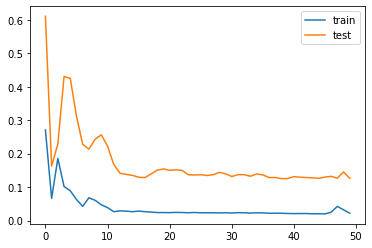

In [25]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 예측 결과 plot

In [26]:
features=[yhat,test_y]

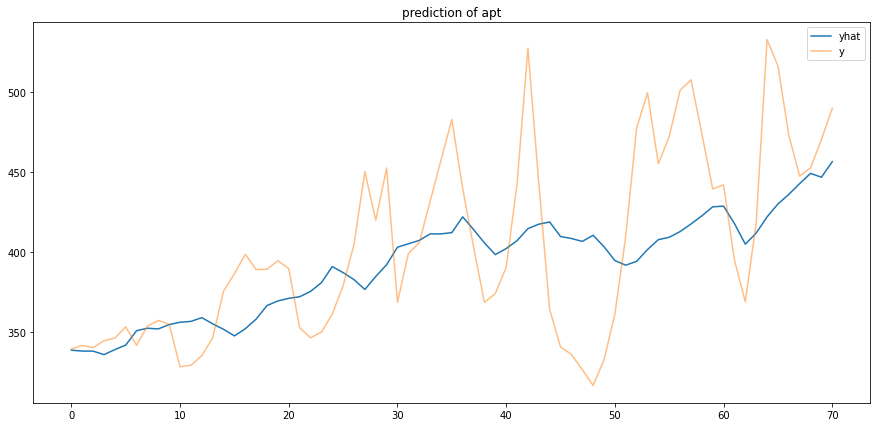

In [27]:
plt.figure(figsize=(15,7))
plt.title('prediction of apt')
plt.plot(yhat,label='yhat')
plt.plot(test_y,alpha=0.5,label='y')
plt.legend()